In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [61]:
import pandas as pd
from preprocess.discretization import discretization, get_nodes_type, code_categories, get_nodes_sign
from bayesian.train_bn import structure_learning, parameter_learning
from block_learning.partial_bn_train import connect_partial_bn, hierarchical_train, direct_connect, direct_train, range_pairs
import seaborn as sns
import numpy as np
from copy import  copy
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN, draw_comparative_hist
import networkx as nx
from pomegranate import log_probability, BayesianNetwork
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [34]:
vk_data = pd.read_csv('../data/vk_data.csv')
vk_data.head(10)

,sex,age,city_id,has_high_education,relation,num_of_relatives,followers_count,status,mobile_phone,twitter,...,"car, cars, sale, tires","sale, clothes, size, price, sewing","ingredients, cooking, dishes, salt, spices","theater, performance, actors","photographer, photography, show, wedding, photographer",top1_interes,top2_interes,top3_interes,top4_interes,top5_interes
0,1,50.0,2,0,0,2,27,0,0,0,...,0.201622,3.397819e-02,0.003674,0.308135,0.010700,"theater, performance, actors","car, cars, sale, tires","participation, festival, exhibition","client, project, internet, business, company","home, renovation, decoration, installation"
1,2,36.0,2,0,0,2,6,0,0,0,...,0.060985,2.529792e-02,0.020964,0.011533,0.003497,"book, reading, language, word, literature","music, concerts, rock, tickets, festivals","school, education, question, topic","client, project, internet, business, company","war, history, army, politics"
2,1,65.0,2,0,0,2,25,0,0,0,...,0.000009,2.007164e-09,0.100547,0.001567,0.049170,"client, project, internet, business, company","skin, face, care, cosmitology","ingredients, cooking, dishes, salt, spices","treatment, doctors, tests, clinic, health","photographer, photography, show, wedding, phot..."
3,2,30.0,2,0,0,2,52,0,1,0,...,0.143803,5.324164e-03,0.027627,0.014820,0.019036,"war, history, army, politics","car, cars, sale, tires","film, series, cinema, genre","music, concerts, rock, tickets, festivals","football, match, russia, team, goalkeeper"
4,2,36.0,2,0,0,2,18,0,0,0,...,0.037360,4.527913e-02,0.087596,0.043889,0.072074,"home, renovation, decoration, installation","ingredients, cooking, dishes, salt, spices","game, team, competition, sport","massage, meditation, yoga","shop, price, gifts, internet"
5,2,22.0,2,1,0,10,167,0,0,0,...,0.025479,1.996316e-02,0.010990,0.033827,0.035163,"music, concerts, rock, tickets, festivals","client, project, internet, business, company","school, education, question, topic","participation, festival, exhibition","film, series, cinema, genre"
6,2,23.0,2,0,0,2,275,1,0,0,...,0.073340,1.916149e-02,0.007811,0.019288,0.023399,"film, series, cinema, genre","car, cars, sale, tires","game, team, competition, sport","participation, festival, exhibition","music, concerts, rock, tickets, festivals"
7,1,27.0,2,0,0,2,475,0,0,0,...,0.005444,5.542228e-02,0.099362,0.061058,0.041686,"film, series, cinema, genre","ingredients, cooking, dishes, salt, spices","participation, festival, exhibition","dress, fashion, color, style","book, reading, language, word, literature"
8,2,25.0,2,0,0,2,37,0,0,0,...,0.052164,1.516378e-02,0.001627,0.020647,0.021668,"music, concerts, rock, tickets, festivals","film, series, cinema, genre","game, team, competition, sport","beauty, hair, manicure, salon","vacation, sea, accommodation, cost"
9,2,35.0,2,0,0,2,41,0,0,0,...,0.056157,5.284686e-02,0.011395,0.032997,0.020119,"home, renovation, decoration, installation","war, history, army, politics","participation, festival, exhibition","film, series, cinema, genre","car, cars, sale, tires"


In [35]:
vk_data = vk_data[['age', 'sex', 'has_high_education', 'relation', 'top1_interes', 'top2_interes', 'top3_interes']]
vk_data.columns = ['age', 'sex', 'has_high_education', 'relation', 'top1_interest', 'top2_interest', 'top3_interest']
vk_data.dropna(inplace=True)
vk_data.reset_index(inplace=True, drop=True)

In [5]:
node_types = get_nodes_type(vk_data)
node_types

{'age': 'cont',
 'sex': 'disc',
 'has_high_education': 'disc',
 'relation': 'disc',
 'top1_interest': 'disc',
 'top2_interest': 'disc',
 'top3_interest': 'disc'}

In [6]:
nodes_sign = get_nodes_sign(vk_data)
nodes_sign

{'age': 'pos'}

In [7]:
coded_data, coder = code_categories(vk_data, 'label', ['top1_interest','top2_interest','top3_interest'])

In [8]:
discrete, est = discretization(coded_data , 'equal_frequency', bins= 5, columns=['age'])

In [9]:
bn = structure_learning(discrete, 'HC', node_types, 'K2')
param = parameter_learning(vk_data, node_types, bn, method='simple')

  0%|          | 11/1000000 [00:00<22:06:18, 12.57it/s]


In [10]:
save_structure(bn, 'K2_bn_structure')
skel = read_structure('K2_bn_structure')
save_params(param, 'K2_bn_param')
params = read_params('K2_bn_param')
full = HyBayesianNetwork(skel, params)

In [36]:
sample = generate_synthetics(full, nodes_sign, 'simple', 30000)

In [12]:
vk_data['sex'] = vk_data['sex'].apply(lambda x: str(x))
sample['sex'] = sample['sex'].apply(lambda x: str(x))
vk_data['has_high_education'] = vk_data['has_high_education'].apply(lambda x: str(x))
sample['has_high_education'] = sample['has_high_education'].apply(lambda x: str(x))
vk_data['relation'] = vk_data['relation'].apply(lambda x: str(x))
sample['relation'] = sample['relation'].apply(lambda x: str(x))

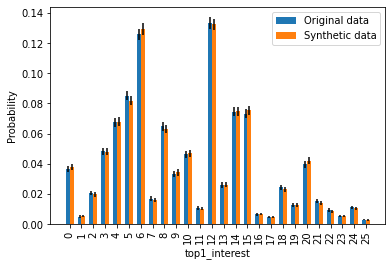

([<matplotlib.axis.XTick at 0x25cd40a90d0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23'),
  Text(24, 0, '24'),
  Text(25, 0, '25'),
  Text(26, 0, '26')])

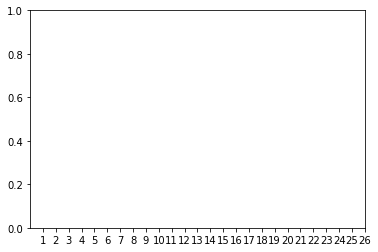

In [13]:
draw_comparative_hist('top1_interest', vk_data, sample, node_types)
plt.xticks([i for i in range (1,27,1)], [i for i in range (1,27,1)])

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

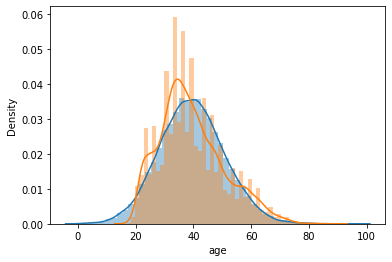

In [14]:
sns.distplot(sample['age'])
sns.distplot(vk_data['age'])

<AxesSubplot:>

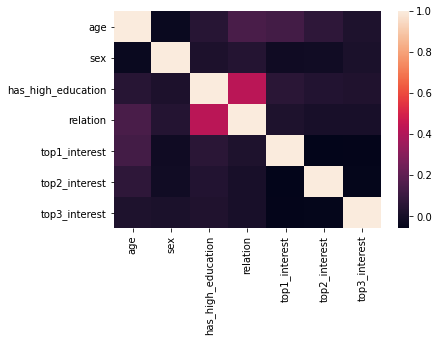

In [21]:
sns.heatmap(coded_data.corr())

In [23]:
sample['sex'] = sample['sex'].apply(lambda x: int(x))
sample['has_high_education'] = sample['has_high_education'].apply(lambda x: int(x))
sample['relation'] = sample['relation'].apply(lambda x: int(x))

In [47]:
sample['top1_interest'] = sample['top1_interest'].apply(lambda x: coder['top1_interest'][x])

In [48]:
sample['top2_interest'] = sample['top2_interest'].apply(lambda x: coder['top2_interest'][x])

In [49]:
sample['top3_interest'] = sample['top3_interest'].apply(lambda x: coder['top3_interest'][x])

In [50]:
sample = sample[['age', 'sex', 'has_high_education', 'relation', 'top1_interest', 'top2_interest', 'top3_interest']]

<AxesSubplot:>

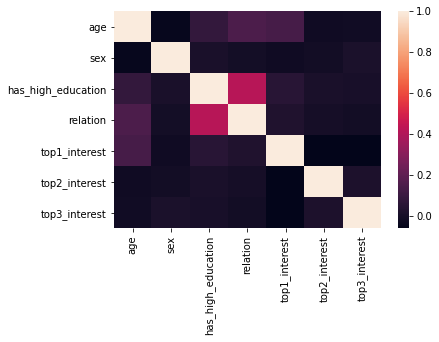

In [32]:
sns.heatmap(sample.corr())

In [56]:
real = copy(coded_data)
real['flag'] = [1 for _ in range(real.shape[0])]

In [53]:
sample['flag'] = [0 for _ in range(sample.shape[0])]

In [39]:
sample = sample[['age', 'sex', 'has_high_education', 'relation', 'top1_interest', 'top2_interest', 'top3_interest', 'flag']]

In [57]:
all_data = pd.concat([real, sample])

In [58]:
train, test = train_test_split(all_data, test_size=0.3)

In [59]:
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

In [60]:
clf = LogisticRegression().fit(train[['age', 'sex', 'has_high_education', 'relation', 'top1_interest', 'top2_interest', 'top3_interest']].values, train['flag'].values)

In [64]:
clf.predict_proba(test[['age', 'sex', 'has_high_education', 'relation', 'top1_interest', 'top2_interest', 'top3_interest']].values)

array([[0.50562673, 0.49437327],
       [0.48995196, 0.51004804],
       [0.49420562, 0.50579438],
       ...,
       [0.50570955, 0.49429045],
       [0.50498524, 0.49501476],
       [0.49416192, 0.50583808]])

In [65]:
roc_auc_score(test['flag'].values, clf.predict_proba(test[['age', 'sex', 'has_high_education', 'relation', 'top1_interest', 'top2_interest', 'top3_interest']].values)[:, 1])

0.4938361496886874